### Setup 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import shutil
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
from sklearn import metrics
from fastai.structured import *
from fastai.column_data import *
import warnings

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
warnings.filterwarnings('ignore')
PATH = '../data/pubg'

### Data Inspection

In [5]:
train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')

In [6]:
train_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


In [10]:
train_df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [17]:
CAT_VARS = ['DBNOs', 'killPlace', 'weaponsAcquired', 'numGroups', 'maxPlace', 'assists', 'boosts',
            'headshotKills', 'heals', 'teamKills', 'vehicleDestroys', 'roadKills', 'revives', 'kills']
CONT_VARS = ['damageDealt', 'killPoints', 'killStreaks', 'longestKill', 'rideDistance', 'swimDistance',
             'walkDistance', 'winPoints']
DROP_VARS = ['matchId', 'groupId', 'Id']
TARGET = 'winPlacePerc'

In [20]:
cv_idxs = get_cv_idxs(len(train_df), val_pct=0.2)

In [23]:
for v in CONT_VARS:
    train_df[v] = train_df[v].astype('float32')
    test_df[v] = test_df[v].astype('float32')
for v in DROP_VARS:
    train_df = train_df.drop(v, axis=1)
    test_df = test_df.drop(v, axis=1)
for v in CAT_VARS:
    train_df[v] = train_df[v].astype('category').cat.as_ordered()
apply_cats(test_df, train_df)

In [24]:
train_df.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'maxPlace', 'numGroups', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [26]:
df, y, nas, mapper = proc_df(train_df, TARGET, do_scale=True)
t_df, _, test_nas, test_mapper = proc_df(test_df, do_scale=True, mapper=mapper, na_dict=nas)

In [28]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs=cv_idxs, df=df, y=y.astype('float32'), cat_flds=CAT_VARS, test_df=t_df, bs=128)

In [32]:
cat_card = [(c, len(train_df[c].cat.categories)) for c in CAT_VARS]
cat_card

[('DBNOs', 40),
 ('killPlace', 100),
 ('weaponsAcquired', 69),
 ('numGroups', 100),
 ('maxPlace', 99),
 ('assists', 20),
 ('boosts', 19),
 ('headshotKills', 25),
 ('heals', 50),
 ('teamKills', 7),
 ('vehicleDestroys', 6),
 ('roadKills', 14),
 ('revives', 22),
 ('kills', 44)]

In [35]:
emb_szs = [(card, min((card+1) // 2, 50)) for _, card in cat_card]
emb_szs

[(40, 20),
 (100, 50),
 (69, 35),
 (100, 50),
 (99, 50),
 (20, 10),
 (19, 10),
 (25, 13),
 (50, 25),
 (7, 4),
 (6, 3),
 (14, 7),
 (22, 11),
 (44, 22)]

In [37]:
learner = md.get_learner(emb_szs, len(df.columns)-len(CAT_VARS), 0.04, 1, [1000, 500], [0.01, 0.01], y_range=[0, 1])

In [38]:
learner.lr_find()

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 16192/27234 [11:25<07:51, 23.40it/s, loss=0.0432]

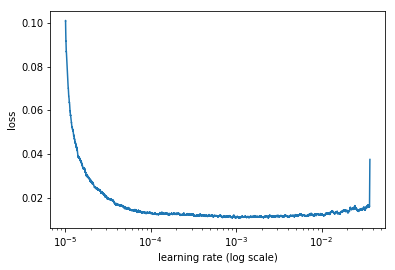

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 16192/27234 [11:40<07:51, 23.40it/s, loss=0.0432]

In [39]:
learner.sched.plot()

In [40]:
learning_rate = 1e-4

In [41]:
learner.fit(learning_rate, 5, cycle_len=1)

epoch      trn_loss   val_loss                                                                                                                                                                                    
    0      0.010154   0.009806  
    1      0.008716   0.008353                                                                                                                                                                                    
    2      0.008367   0.007962                                                                                                                                                                                    
    3      0.007813   0.007833                                                                                                                                                                                    
    4      0.007945   0.007751                                                                                             

[0.007750639909457549]

In [42]:
learner.save('pubg_1000_500')

In [43]:
learner.load('pubg_1000_500')

In [44]:
learner.fit(learning_rate, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                                                                    
    0      0.007775   0.007693  
    1      0.007821   0.007728                                                                                                                                                                                    
    2      0.007796   0.007583                                                                                                                                                                                    


[0.007582951097231417]

In [45]:
learner.save('pubg_1000_500_v2')

In [46]:
learner.load('pubg_1000_500_v2')

In [47]:
pred_v2 = learner.predict(is_test=True)

In [48]:
learner.load('pubg_1000_500')

In [49]:
pred_v1 = learner.predict(is_test=True)

In [51]:
pred_v1_series = pred_v1.flatten()

In [52]:
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df.insert(len(test_df.columns), 'winPlacePerc', pred_v1_series)

In [55]:
test_df[['Id', 'winPlacePerc']].to_csv(f'{PATH}/submit.gz', compression='gzip', index=False)
FileLink(f'{PATH}/submit.gz')

C:\Users\I863552\Documents\fastai\courses\dl1\data\pubg\submit.gz

In [56]:
pred_v2_series = pred_v2.flatten()

In [57]:
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df.insert(len(test_df.columns), 'winPlacePerc', pred_v2_series)

In [61]:
test_df[['Id', 'winPlacePerc']].to_csv(f'{PATH}/submit2.csv', index=False)
FileLink(f'{PATH}/submit2.csv')

C:\Users\I863552\Documents\fastai\courses\dl1\data\pubg\submit2.csv

In [64]:
learner.fit(learning_rate, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                                                                    
    0      0.007885   0.007689  
    1      0.00768    0.007727                                                                                                                                                                                    
    2      0.007977   0.007584                                                                                                                                                                                    


[0.007583876346371856]

In [65]:
learner.save('pubg_1000_500_v3')

In [66]:
learner.load('pubg_1000_500_v3')

In [67]:
pred_v3 = learner.predict(is_test=True)

In [68]:
pred_v3_series = pred_v3.flatten()

In [72]:
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df.insert(len(test_df.columns), 'winPlacePerc', pred_v3_series)

In [73]:
test_df[['Id', 'winPlacePerc']].to_csv(f'{PATH}/submit_v3.csv', index=False)
FileLink(f'{PATH}/submit_v3.csv')

C:\Users\I863552\Documents\fastai\courses\dl1\data\pubg\submit_v3.csv

In [71]:
learner.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                                                                    
    0      0.007809   0.007564  
    1      0.007483   0.00762                                                                                                                                                                                     
    2      0.007326   0.007512                                                                                                                                                                                    
    3      0.007651   0.0077                                                                                                                                                                                      
    4      0.007636   0.007561                                                                                             

[0.0074561668831371625]

In [74]:
pred_v4 = learner.predict(is_test=True)

In [75]:
pred_v4_series = pred_v4.flatten()

In [76]:
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df.insert(len(test_df.columns), 'winPlacePerc', pred_v4_series)

In [77]:
test_df[['Id', 'winPlacePerc']].to_csv(f'{PATH}/submit_v4.csv', index=False)
FileLink(f'{PATH}/submit_v4.csv')

C:\Users\I863552\Documents\fastai\courses\dl1\data\pubg\submit_v4.csv